# Purpose
- Gather calcium and spike data
- z-scoring
- Match with frame_whisker_behavior dataset
- Calculate touch response per trial (before and after decision lick)
- Per neuron activity pattern change across training
- Population activity pattern change across training
- Focus on 2-angle training sessions only

<br>
Continued from 220924_final_signal_extraction.ipynb & 221024_build_dataset.ipynb

In [162]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import os, glob, h5py
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import notebook
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

h5_dir_1 = Path('H:/')
h5_dir_2 = Path('F:/')
b_dir = Path('D:/SoloData/')
w_dir = Path('D:/WhiskerVideo/')
mice =          [25,    27,   30,   36,     37,     38,     39,     41,     52,     53,     54,     56]
expert_mice = [25, 27, 30, 36, 39, 52]
# refSessions =   [4,     3,    3,    1,      7,      2,      1,      3,      3,      3,      3,      3]
# expSessions =   [19,    10,   21,   17,     0,      0,      23,     0,      21,     0,      0,      0]
# zoom =          [2,     2,    2,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7]
image_rate_list = [30.8359, 30.8359, 30.8359, 30.8359, 
                    24.2892, 24.2892, 24.2892, 24.2892,
                    30.8359, 30.8359, 30.8359, 30.8359] # from .mat file (sbx)
image_size_list = [[512,796], [512,796], [512,796], [512,796], 
                    [650,796], [650,796], [650,796], [650,796], 
                    [512,796], [512,796], [512,796], [512,796]] # from .mat file (sbx)
planes = range(1,9)

save_dir = Path('C:\JK')

In [26]:
emi = 0
plane = 1

mouse = expert_mice[emi]
if emi < 3:
    h5_dir = h5_dir_1
else:
    h5_dir = h5_dir_2

plane_dir = h5_dir / f'{mouse:03d}' / f'plane_{plane}'
sts_reg = np.load(plane_dir / f'JK{mouse:03d}_plane{plane}_session_to_session_registration.npy', allow_pickle=True).item()
session_nums = sts_reg['selected_session_num']
# This info is valid in pi:pi+4

# for session_num in session_nums:
#     if session_num > 900:
#         wb_snum = session_num // 10 + session_num % 900 # pre1 is 901 in calcium but 91 in behavior and whisker
#     else:
#         wb_snum = session_num

In [5]:
sts_reg.keys()

dict_keys(['mouse', 'plane', 'edge_buffer', 'selected_session_i', 'selected_session_num', 'zdrift_list', 'registration_method', 'bilinear_result', 'affine_result', 'suite2p_result', 'old_result'])

In [12]:
len(sts_reg['selected_session_num'])

13

In [6]:
roi_collection_fn = f'JK{mouse:03d}_plane{plane}_roi_collection_filtered.npy'
roi_collection = np.load(plane_dir / roi_collection_fn, allow_pickle=True).item()
roi_collection.keys()

dict_keys(['final_master_map_sessions', 'final_viable_cell_index_list', 'final_matching_master_roi_index_list', 'filtered_matching_master_roi_index_list'])

In [24]:
# Total ROIs in each session
# - some might be 'not cell': look up iscell.npy
[rcmap.shape for rcmap in roi_collection['final_master_map_sessions']]

[(155, 327, 627),
 (155, 327, 627),
 (155, 327, 627),
 (155, 327, 627),
 (155, 327, 627),
 (155, 327, 627),
 (155, 327, 627),
 (155, 327, 627),
 (155, 327, 627),
 (155, 327, 627),
 (155, 327, 627),
 (155, 327, 627),
 (155, 327, 627)]

In [22]:
# Index of filtered master map ROI, corresponding to each ROI in equal_lam (session-curated ROI)
# Index matches to the index of 'iscell' ROIs in each session equal_lam
# Length indicates # of such ROIs in each session
[len(rc) for rc in roi_collection['filtered_matching_master_roi_index_list']]

[58, 59, 66, 60, 47, 65, 51, 53, 25, 52, 50, 64, 63]

In [28]:
session_nums

array([ 1,  2,  3,  4,  5,  6, 13, 15, 17, 19, 22, 23, 24])

In [333]:
si = 0
session_num = session_nums[si]
session_roi_dir = plane_dir / f'{session_num:03d}' / 'plane0' / 'filtered_master_map'
iscell = np.load(session_roi_dir / 'iscell.npy', allow_pickle=True)[:,0] # Same for all sessions in a plane
events = np.load(session_roi_dir / 'spks.npy', allow_pickle=True).transpose() # To make each cell in each column, and column-direction matches with whisker-behavior dataFrame.
events_zscore = (events - np.mean(events, axis=0)) / np.std(events, axis=0)
print(f'Session {session_num:02d}')
print(events.shape)
print(len(np.where(iscell==1)[0]))
events.shape[1] == len(iscell)

Session 01
(5006, 155)
155


True

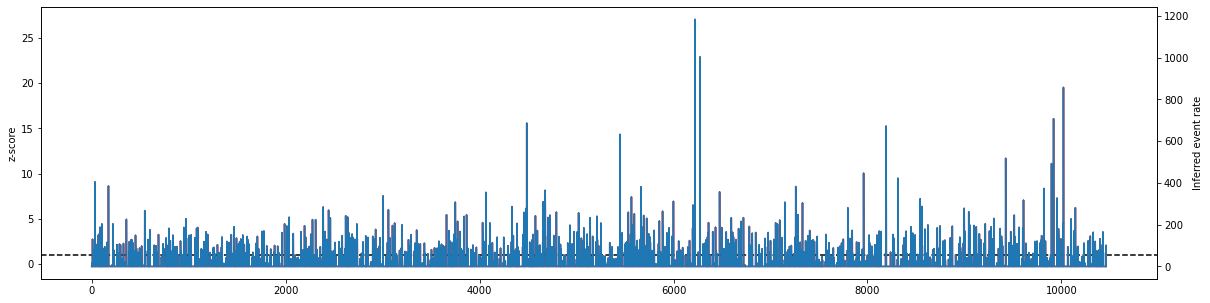

In [180]:
# Single neuron test
ci = 150
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(events_zscore[:,ci], 'r')
ax.set_ylabel('z-score')
ax2 = ax.twinx()
ax2.plot(events[:,ci])
ax2.set_ylabel('Inferred event rate')
ax.axhline(1, color='k', linestyle='--')

In [330]:
# Plot events and z-scores across sessions
# Select regular training sessions only (for now)
si = 1
session_num = session_nums[si]
wb_df = pd.read_pickle(plane_dir / f'JK{mouse:03d}_S{session_num:02d}_plane{plane}_frame_whisker_behavior.pkl')
np.sort(wb_df.keys())

array(['answer_lick_frame', 'answer_lick_left', 'answer_lick_right',
       'answer_period_frame', 'arc_length_onset', 'correct',
       'delta_kappaH', 'delta_kappaV', 'delta_phi', 'delta_theta',
       'distractor', 'first_reward_lick_frame', 'first_reward_lick_left',
       'first_reward_lick_right', 'frame_end_time', 'frame_index',
       'frame_start_time', 'kappaH_onset', 'kappaV_onset', 'miss',
       'mouse_name', 'num_lick_left', 'num_lick_right', 'phi_onset',
       'pole_angle', 'pole_ap_distance', 'pole_moving_frame',
       'pole_radial_distance', 'pole_up_frame',
       'post_answer_pole_up_frame', 'pre_answer_pole_up_frame',
       'session_name', 'session_type', 'slide_distance', 'task_target',
       'theta_onset', 'touch_count', 'touch_duration', 'trialNum',
       'trial_duration', 'trial_type', 'wrong'], dtype=object)

In [384]:
# Function calculating correct rate
def calculate_correct_rate(wb_df):
    temp_df = wb_df.drop_duplicates('trialNum')[['trialNum','correct','wrong','miss']]
    num_trials = len(temp_df)
    num_correct = temp_df.correct.sum()
    num_wrong = temp_df.wrong.sum()
    num_miss = temp_df.miss.sum()
    num_answer = num_correct + num_wrong
    assert num_correct + num_wrong + num_miss == num_trials
    answer_rate = 1 - num_miss / num_trials
    correct_rate = num_correct / num_trials
    return correct_rate, num_answer, answer_rate

# Single plane single session test

In [391]:
# Per trial touch response
# Pre-answer (including the answer lick frame) and post-answer (starting AFTER the answer lick frame)
# Response amplitue (in terms of z-score)
# Divided by the total # of touches within the window
# Responsiveness, tested by t-test to the values before pole up (up until the first pole moving or pole up frame, whichever is faster)
emi = 0
plane = 1

mouse = expert_mice[emi]
if emi < 3:
    h5_dir = h5_dir_1
else:
    h5_dir = h5_dir_2

plane_dir = h5_dir / f'{mouse:03d}' / f'plane_{plane}'
sts_reg = np.load(plane_dir / f'JK{mouse:03d}_plane{plane}_session_to_session_registration.npy', allow_pickle=True).item()
session_nums = sts_reg['selected_session_num']

si = 0
session_num = session_nums[si]
session_plane_info = f'JK{mouse:03d} S{session_num:02d} plane{plane}'

# Load events
session_roi_dir = plane_dir / f'{session_num:03d}' / 'plane0' / 'filtered_master_map'
iscell = np.load(session_roi_dir / 'iscell.npy', allow_pickle=True)[:,0] # Same for all sessions in a plane
events = np.load(session_roi_dir / 'spks.npy', allow_pickle=True).transpose() # To make each cell in each column, and column-direction matches with whisker-behavior dataFrame.
events_zscore = (events - np.mean(events, axis=0)) / np.std(events, axis=0)
print(f'Session {session_num:02d}')
print(events.shape)
print(len(np.where(iscell==1)[0]))
events.shape[1] == len(iscell)


events = events[:,np.where(iscell)[0]]
events_zscore = events_zscore[:,np.where(iscell)[0]]

# load whisker-behavior dataFrame
wb_df = pd.read_pickle(plane_dir / f'JK{mouse:03d}_S{session_num:02d}_plane{plane}_frame_whisker_behavior.pkl')

trial_start_buffer_frame = 3 # to prevent abrupt increase of signal by laser on after ITI and possible contamination by trial start cue
trial_nums = wb_df.trialNum.unique()
pre_pole_activity = np.empty((len(trial_nums), events_zscore.shape[1]))
pre_pole_activity[:] = np.nan
pre_answer_response = np.empty((len(trial_nums), events_zscore.shape[1]))
pre_answer_response[:] = np.nan
post_answer_response = np.empty((len(trial_nums), events_zscore.shape[1]))
post_answer_response[:] = np.nan
post_pole_activity = np.empty((len(trial_nums), events_zscore.shape[1]))
post_pole_activity[:] = np.nan
pre_pole_length = np.zeros(len(trial_nums))

for ti, trial_num in enumerate(trial_nums):
    trial_wb_df = wb_df[wb_df.trialNum == trial_num]
    if (not trial_wb_df.iloc[0].miss) and (np.nansum(trial_wb_df.touch_count.values) > 0): # only when there was an answer and at least one touch
        trial_events_zscore = events_zscore[np.where(wb_df.trialNum == trial_num)[0],:]
        if len(np.where(trial_wb_df.pole_moving_frame.values)[0]) > 0:
            first_pole_moving_ind = min(np.where(trial_wb_df.pole_up_frame.values)[0][0], np.where(trial_wb_df.pole_moving_frame.values)[0][0])
        else:
            first_pole_moving_ind = np.where(trial_wb_df.pole_up_frame.values)[0][0]
        pre_pole_inds = range(trial_start_buffer_frame,first_pole_moving_ind)
        pre_pole_length[ti] = len(pre_pole_inds)
        pre_answer_pole_inds = range(np.where(trial_wb_df.pre_answer_pole_up_frame.values)[0][0], np.where(trial_wb_df.pre_answer_pole_up_frame.values)[0][-1] +2)
        pre_answer_num_touch = np.nansum(trial_wb_df.touch_count.values[pre_answer_pole_inds])

        post_answer_pole_inds = np.where(trial_wb_df.post_answer_pole_up_frame.values)[0] # last frame should be included
        post_pole_inds = []
        if len(post_answer_pole_inds) > 0:
            assert post_answer_pole_inds[0] - pre_answer_pole_inds[-1] == 1
            post_answer_num_touch = np.nansum(trial_wb_df.touch_count.values[post_answer_pole_inds])
            if len(trial_wb_df) > post_answer_pole_inds[-1]:
                post_pole_inds = range(post_answer_pole_inds[-1]+1, len(trial_wb_df))
        else:
            post_answer_num_touch = 0
        
        assert len(np.intersect1d(pre_pole_inds, pre_answer_pole_inds))==0
        assert len(np.intersect1d(pre_answer_pole_inds, post_answer_pole_inds))==0
        
        pre_pole_activity[ti,:] = np.mean(trial_events_zscore[pre_pole_inds, :], axis=0)
        if pre_answer_num_touch > 0:
            pre_answer_response[ti,:] = np.mean(trial_events_zscore[pre_answer_pole_inds,:], axis=0) / pre_answer_num_touch
        if post_answer_num_touch > 0:
            post_answer_response[ti,:] = np.mean(trial_events_zscore[post_answer_pole_inds,:], axis=0) / post_answer_num_touch
        if len(post_pole_inds) > 0:
            post_pole_activity[ti,:] = np.mean(trial_events_zscore[post_pole_inds, :], axis=0)



Session 01
(5006, 155)
155


In [336]:
print(np.mean(pre_pole_length))
print(np.std(pre_pole_length))

2.7333333333333334
2.3879326251429758


In [392]:
# Calculating p-values
pvalue_pre_answer_response = stats.ttest_1samp(pre_answer_response - pre_pole_activity, 0, nan_policy='omit')[1].data
pvalue_post_answer_response = stats.ttest_1samp(post_answer_response - pre_pole_activity, 0, nan_policy='omit')[1].data
pvalue_post_pre_answer = stats.ttest_1samp(post_answer_response - pre_answer_response, 0, nan_policy='omit')[1].data

56
0


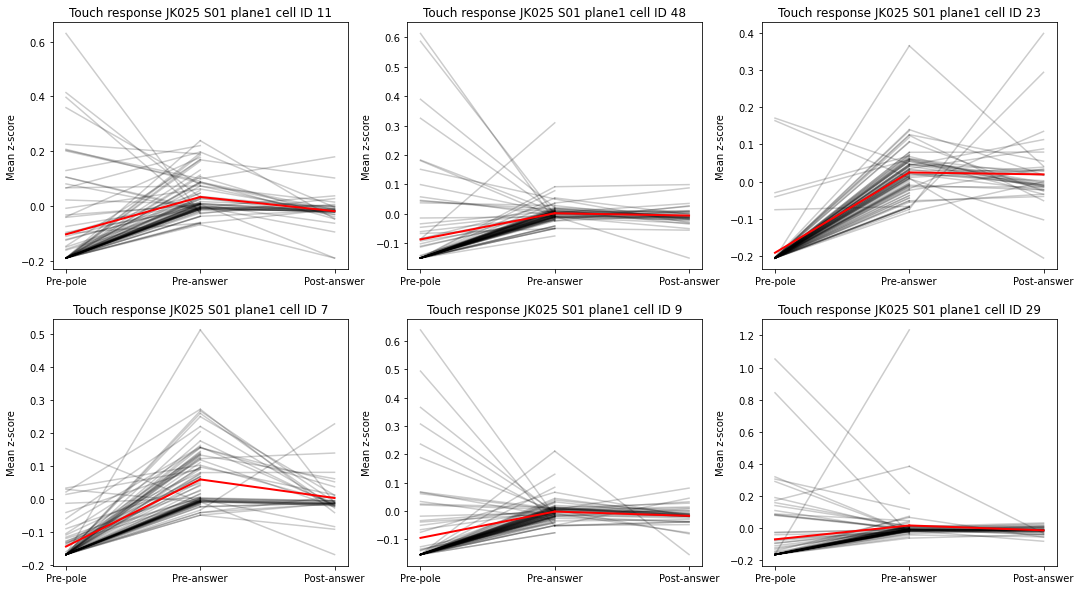

In [393]:
# Test the p-value by plotting individual cell
p001_pre_answer_ind = np.where(pvalue_pre_answer_response<0.001)[0]
print(len(p001_pre_answer_ind))
negative_response_ind = np.where(np.nanmean(pre_answer_response, axis=0) - np.nanmean(pre_pole_activity, axis=0) < 0)[0]
print(len(np.intersect1d(negative_response_ind, p001_pre_answer_ind)))
rand_inds = np.random.choice(p001_pre_answer_ind,6)
fig, ax = plt.subplots(2,3,figsize=(18,10))
for i, ind in enumerate(rand_inds):
    iy = i // 3
    ix = i % 3
    for ii in range(pre_pole_activity.shape[0]):
        ax[iy,ix].plot([1,2], [pre_pole_activity[ii,ind], pre_answer_response[ii,ind]], 'k-', alpha=0.2)
        ax[iy,ix].plot([2,3], [pre_answer_response[ii,ind], post_answer_response[ii,ind]], 'k-', alpha=0.2)
    ax[iy,ix].plot([1,2], [np.nanmean(pre_pole_activity[:,ind]), np.nanmean(pre_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].plot([2,3], [np.nanmean(pre_answer_response[:,ind]), np.nanmean(post_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].set_xticks([1,2,3])
    ax[iy,ix].set_xticklabels(['Pre-pole', 'Pre-answer', 'Post-answer'])
    ax[iy,ix].set_ylabel('Mean z-score')
    ax[iy,ix].set_title(f'Touch response {session_plane_info} cell ID {ind}')


Text(0.5, 1.0, 'JK025 S01 plane1: All cells\nmean=-0.2527 p=2.0847e-36')

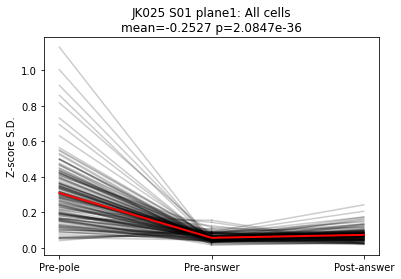

In [394]:
# Reduced variability?
p_std_change = stats.ttest_1samp(np.nanstd(pre_answer_response, axis=0) - np.nanstd(pre_pole_activity, axis=0), 0).pvalue
mean_std_change = np.mean(np.nanstd(pre_answer_response, axis=0) - np.nanstd(pre_pole_activity, axis=0))
fig, ax = plt.subplots()
pre_answer_std = np.nanstd(pre_answer_response, axis=0)
pre_pole_std = np.nanstd(pre_pole_activity, axis=0)
post_answer_std = np.nanstd(post_answer_response, axis=0)
for ii in range(pre_answer_response.shape[0]):
    ax.plot([1,2], [pre_pole_std[ii], pre_answer_std[ii]], 'k-', alpha=0.2)
ax.plot([1,2], [np.mean(pre_pole_std), np.mean(pre_answer_std)], 'r-', linewidth=2)
for ii in range(pre_answer_response.shape[0]):
    ax.plot([2,3], [pre_answer_std[ii], post_answer_std[ii]], 'k-', alpha=0.2)
ax.plot([2,3], [np.mean(pre_answer_std), np.mean(post_answer_std)], 'r-', linewidth=2)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Pre-pole', 'Pre-answer', 'Post-answer'])
ax.set_ylabel('Z-score S.D.')
ax.set_title(f'{session_plane_info}: All cells\nmean={mean_std_change:.4f} p={p_std_change:.4e}')

Text(0.5, 1.0, 'JK025 S01 plane1 Pre-answer - pre-pole; p < 0.001\nmean=-0.0929 p=3.0520e-13')

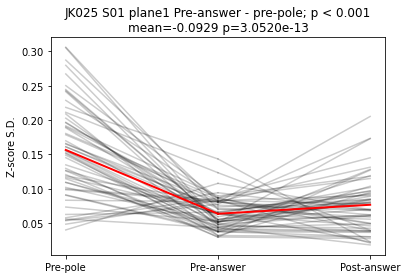

In [395]:
# What about p<0.001 cells?
p_std_change = stats.ttest_1samp(np.nanstd(pre_answer_response[:,p001_pre_answer_ind], axis=0) - np.nanstd(pre_pole_activity[:,p001_pre_answer_ind], axis=0), 0).pvalue
mean_std_change = np.mean(np.nanstd(pre_answer_response[:,p001_pre_answer_ind], axis=0) - np.nanstd(pre_pole_activity[:,p001_pre_answer_ind], axis=0))

fig, ax = plt.subplots()
pre_answer_std = np.nanstd(pre_answer_response[:,p001_pre_answer_ind], axis=0)
pre_pole_std = np.nanstd(pre_pole_activity[:,p001_pre_answer_ind], axis=0)
post_answer_std = np.nanstd(post_answer_response[:,p001_pre_answer_ind], axis=0)
for ii in range(len(p001_pre_answer_ind)):
    ax.plot([1,2], [pre_pole_std[ii], pre_answer_std[ii]], 'k-', alpha=0.2)
ax.plot([1,2], [np.mean(pre_pole_std), np.mean(pre_answer_std)], 'r-', linewidth=2)
for ii in range(len(p001_pre_answer_ind)):
    ax.plot([2,3], [pre_answer_std[ii], post_answer_std[ii]], 'k-', alpha=0.2)
ax.plot([2,3], [np.mean(pre_answer_std), np.mean(post_answer_std)], 'r-', linewidth=2)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Pre-pole', 'Pre-answer', 'Post-answer'])
ax.set_ylabel('Z-score S.D.')
ax.set_title(f'{session_plane_info} Pre-answer - pre-pole; p < 0.001\nmean={mean_std_change:.4f} p={p_std_change:.4e}')

20
0


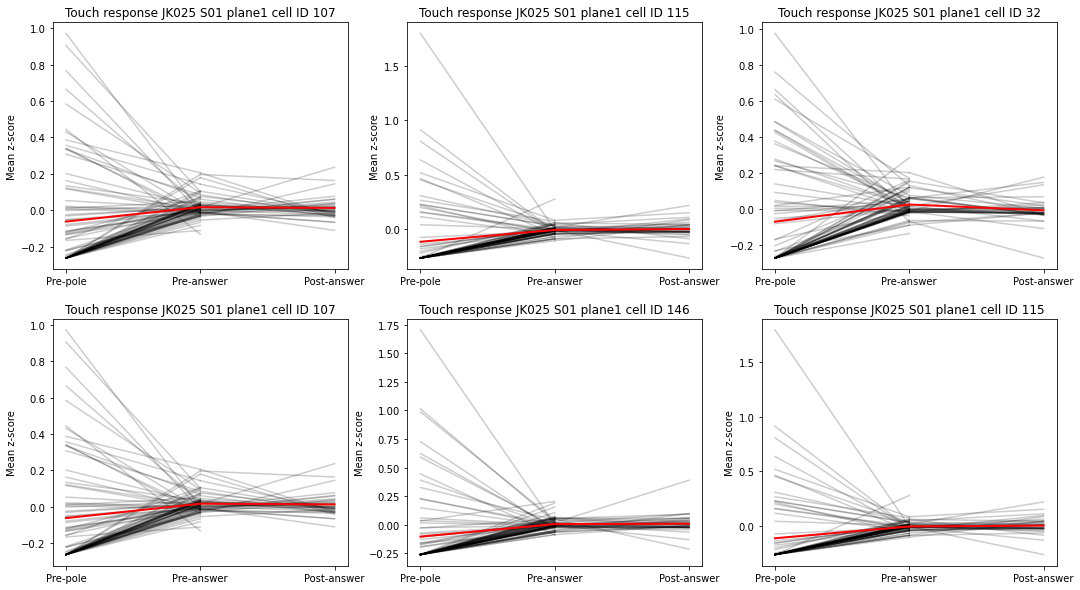

In [378]:
# 0.001 <= p < 0.01
p01_pre_answer_ind = np.setdiff1d(np.where(pvalue_pre_answer_response<0.01)[0], np.where(pvalue_pre_answer_response<0.001)[0])
print(len(p01_pre_answer_ind))
negative_response_ind = np.where(np.nanmean(pre_answer_response, axis=0) - np.nanmean(pre_pole_activity, axis=0) < 0)[0]
print(len(np.intersect1d(negative_response_ind, p01_pre_answer_ind)))
rand_inds = np.random.choice(p01_pre_answer_ind,6)
fig, ax = plt.subplots(2,3,figsize=(18,10))
for i, ind in enumerate(rand_inds):
    iy = i // 3
    ix = i % 3
    for ii in range(pre_pole_activity.shape[0]):
        ax[iy,ix].plot([1,2], [pre_pole_activity[ii,ind], pre_answer_response[ii,ind]], 'k-', alpha=0.2)
        ax[iy,ix].plot([2,3], [pre_answer_response[ii,ind], post_answer_response[ii,ind]], 'k-', alpha=0.2)
    ax[iy,ix].plot([1,2], [np.nanmean(pre_pole_activity[:,ind]), np.nanmean(pre_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].plot([2,3], [np.nanmean(pre_answer_response[:,ind]), np.nanmean(post_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].set_xticks([1,2,3])
    ax[iy,ix].set_xticklabels(['Pre-pole', 'Pre-answer', 'Post-answer'])
    ax[iy,ix].set_ylabel('Mean z-score')
    ax[iy,ix].set_title(f'Touch response {session_plane_info} cell ID {ind}')

15
0


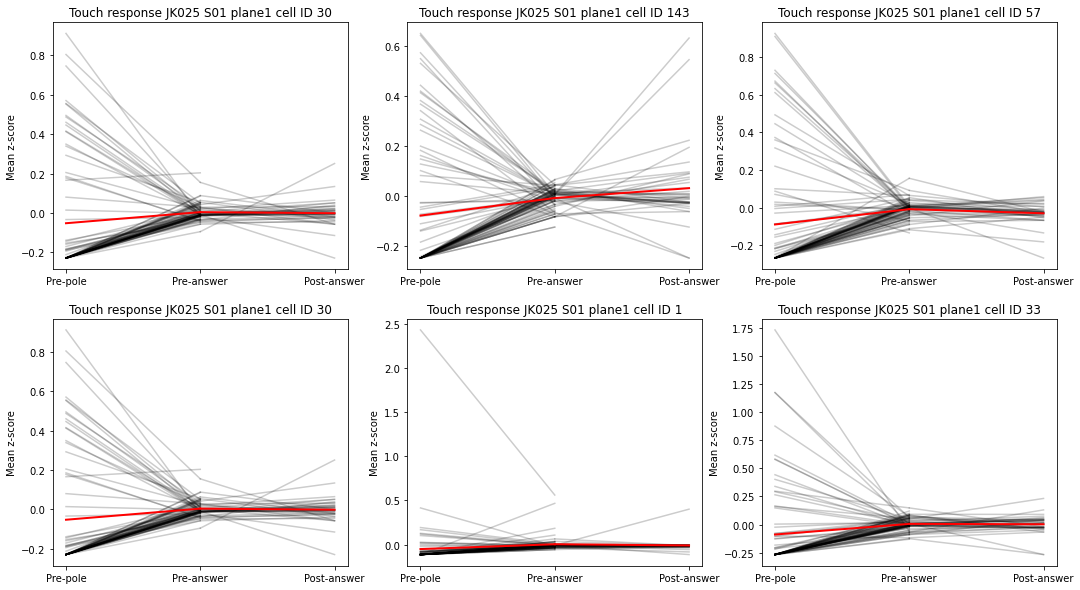

In [379]:
# 0.01 <= p < 0.05
p05_pre_answer_ind = np.setdiff1d(np.where(pvalue_pre_answer_response<0.05)[0], np.where(pvalue_pre_answer_response<0.01)[0])
print(len(p05_pre_answer_ind))
negative_response_ind = np.where(np.nanmean(pre_answer_response, axis=0) - np.nanmean(pre_pole_activity, axis=0) < 0)[0]
print(len(np.intersect1d(negative_response_ind, p05_pre_answer_ind)))
rand_inds = np.random.choice(p05_pre_answer_ind,6)
fig, ax = plt.subplots(2,3,figsize=(18,10))
for i, ind in enumerate(rand_inds):
    iy = i // 3
    ix = i % 3
    for ii in range(pre_pole_activity.shape[0]):
        ax[iy,ix].plot([1,2], [pre_pole_activity[ii,ind], pre_answer_response[ii,ind]], 'k-', alpha=0.2)
        ax[iy,ix].plot([2,3], [pre_answer_response[ii,ind], post_answer_response[ii,ind]], 'k-', alpha=0.2)
    ax[iy,ix].plot([1,2], [np.nanmean(pre_pole_activity[:,ind]), np.nanmean(pre_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].plot([2,3], [np.nanmean(pre_answer_response[:,ind]), np.nanmean(post_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].set_xticks([1,2,3])
    ax[iy,ix].set_xticklabels(['Pre-pole', 'Pre-answer', 'Post-answer'])
    ax[iy,ix].set_ylabel('Mean z-score')
    ax[iy,ix].set_title(f'Touch response {session_plane_info} cell ID {ind}')

# Run all the sessions in a plane
- 2-angle training sessions only

In [402]:
trial_start_buffer_frame = 3 # to prevent abrupt increase of signal by laser on after ITI and possible contamination by trial start cue

for emi in range(3):
    for plane in range(1,9):

        mouse = expert_mice[emi]
        if emi < 3:
            h5_dir = h5_dir_1
        else:
            h5_dir = h5_dir_2

        plane_dir = h5_dir / f'{mouse:03d}' / f'plane_{plane}'
        sts_reg = np.load(plane_dir / f'JK{mouse:03d}_plane{plane}_session_to_session_registration.npy', allow_pickle=True).item()
        session_nums = sts_reg['selected_session_num']

        tr_sessions = [] # touch response sessions
        tr_num_roi = []
        tr_correct_rate = []
        tr_num_answer = []
        tr_num_touch_trials = []
        tr_pre_pole_len = []
        tr_angle = []
        tr_correct = []
        tr_num_pre_answer_touch = []
        tr_num_post_answer_touch = []

        tr_p_pre_answer = []
        tr_p_post_answer = []
        tr_p_post_pre = []
        tr_effect_pre_answer = []
        tr_effect_post_answer = []
        tr_effect_post_pre = []

        tr_pre_pole_activity = []
        tr_pre_answer_response = []
        tr_post_answer_response = []
        tr_post_pole_activity = []

        # Load iscell, which is same for all the sessions in a plane
        session_num = session_nums[0]
        session_roi_dir = plane_dir / f'{session_num:03d}' / 'plane0' / 'filtered_master_map'
        iscell = np.load(session_roi_dir / 'iscell.npy', allow_pickle=True)[:,0] # Same for all sessions in a plane
        iscell_ind = np.where(iscell)[0]
        num_cell = len(iscell_ind)
        for session_num in session_nums:
            session_plane_info = f'JK{mouse:03d} S{session_num:02d} plane{plane}'
            print(f'Processing {session_plane_info}')
            
            # Load events and z-score them
            session_roi_dir = plane_dir / f'{session_num:03d}' / 'plane0' / 'filtered_master_map'
            events = np.load(session_roi_dir / 'spks.npy', allow_pickle=True).transpose() # To make each cell in each column, and column-direction matches with whisker-behavior dataFrame.
            events_zscore = (events - np.mean(events, axis=0)) / np.std(events, axis=0)
            assert events.shape[1] == len(iscell)
            events_zscore = events_zscore[:,iscell_ind]

            # Load whisker-behavior dataFrame
            wb_pkl_fn = f'JK{mouse:03d}_S{session_num:02d}_plane{plane}_frame_whisker_behavior.pkl'
            if os.path.isfile(plane_dir / wb_pkl_fn):
                wb_df = pd.read_pickle(plane_dir / wb_pkl_fn)
                if wb_df.task_target.values[-1] == 'Angle': # 2-angle training sessions only
                    if np.nansum(wb_df.touch_count.values) > 0: # removing whisker-less sessions
                        correct_rate, num_answer, answer_rate = calculate_correct_rate(wb_df)
                        
                        trial_nums = wb_df.trialNum.unique()
                        pre_pole_activity = np.empty((len(trial_nums), events_zscore.shape[1]))
                        pre_pole_activity[:] = np.nan
                        pre_answer_response = np.empty((len(trial_nums), events_zscore.shape[1]))
                        pre_answer_response[:] = np.nan
                        post_answer_response = np.empty((len(trial_nums), events_zscore.shape[1]))
                        post_answer_response[:] = np.nan
                        post_pole_activity = np.empty((len(trial_nums), events_zscore.shape[1]))
                        post_pole_activity[:] = np.nan
                        pre_pole_length = np.empty(len(trial_nums),)
                        pre_pole_length[:] = np.nan
                        angle = np.empty(len(trial_nums),)
                        angle[:] = np.nan
                        correct = np.empty(len(trial_nums),)
                        correct[:] = np.nan
                        num_pre_answer_touch = np.empty(len(trial_nums),)
                        num_pre_answer_touch[:] = np.nan
                        num_post_answer_touch = np.empty(len(trial_nums),)
                        num_post_answer_touch[:] = np.nan
                        num_touch_trial = 0
                        for ti, trial_num in enumerate(trial_nums):
                            trial_wb_df = wb_df[wb_df.trialNum == trial_num]
                            if (not trial_wb_df.iloc[0].miss) and (np.nansum(trial_wb_df.touch_count.values) > 0): # only when there was an answer and at least one touch
                                num_touch_trial += 1

                                angle[ti] = trial_wb_df.iloc[0].pole_angle
                                correct[ti] = trial_wb_df.iloc[0].correct
                                
                                trial_events_zscore = events_zscore[np.where(wb_df.trialNum == trial_num)[0],:]
                                if len(np.where(trial_wb_df.pole_moving_frame.values)[0]) > 0:
                                    first_pole_moving_ind = min(np.where(trial_wb_df.pole_up_frame.values)[0][0], np.where(trial_wb_df.pole_moving_frame.values)[0][0])
                                else:
                                    first_pole_moving_ind = np.where(trial_wb_df.pole_up_frame.values)[0][0]
                                pre_pole_inds = range(trial_start_buffer_frame,first_pole_moving_ind)
                                pre_pole_length[ti] = len(pre_pole_inds)
                                pre_answer_pole_inds = range(np.where(trial_wb_df.pre_answer_pole_up_frame.values)[0][0], np.where(trial_wb_df.pre_answer_pole_up_frame.values)[0][-1] +2)
                                pre_answer_num_touch = np.nansum(trial_wb_df.touch_count.values[pre_answer_pole_inds])

                                post_answer_pole_inds = np.where(trial_wb_df.post_answer_pole_up_frame.values)[0] # last frame should be included
                                post_pole_inds = []
                                
                                if len(post_answer_pole_inds) > 0:
                                    assert post_answer_pole_inds[0] - pre_answer_pole_inds[-1] == 1
                                    post_answer_num_touch = np.nansum(trial_wb_df.touch_count.values[post_answer_pole_inds])
                                    if len(trial_wb_df) > post_answer_pole_inds[-1]:
                                        post_pole_inds = range(post_answer_pole_inds[-1]+1, len(trial_wb_df))
                                else:
                                    post_answer_num_touch = 0
                                
                                num_pre_answer_touch[ti] = pre_answer_num_touch
                                num_post_answer_touch[ti] = post_answer_num_touch

                                assert len(np.intersect1d(pre_pole_inds, pre_answer_pole_inds))==0
                                assert len(np.intersect1d(pre_answer_pole_inds, post_answer_pole_inds))==0
                                
                                pre_pole_activity[ti,:] = np.mean(trial_events_zscore[pre_pole_inds, :], axis=0)
                                if pre_answer_num_touch > 0:
                                    pre_answer_response[ti,:] = np.mean(trial_events_zscore[pre_answer_pole_inds,:], axis=0) / pre_answer_num_touch
                                if post_answer_num_touch > 0:
                                    post_answer_response[ti,:] = np.mean(trial_events_zscore[post_answer_pole_inds,:], axis=0) / post_answer_num_touch
                                if len(post_pole_inds) > 0:
                                    post_pole_activity[ti,:] = np.mean(trial_events_zscore[post_pole_inds, :], axis=0)
                        
                        pvalue_pre_answer_response = stats.ttest_1samp(pre_answer_response - pre_pole_activity, 0, nan_policy='omit')[1].data
                        pvalue_post_answer_response = stats.ttest_1samp(post_answer_response - pre_pole_activity, 0, nan_policy='omit')[1].data
                        pvalue_post_pre_answer = stats.ttest_1samp(post_answer_response - pre_answer_response, 0, nan_policy='omit')[1].data
                        effect_pre_answer_response = np.nanmean(pre_answer_response - pre_pole_activity, axis=0)
                        effect_post_answer_response = np.nanmean(post_answer_response - pre_pole_activity, axis=0)
                        effect_post_pre_answer = np.nanmean(post_answer_response - pre_answer_response, axis=0)

                        # Collect the results
                        tr_sessions.append(session_num)
                        tr_num_roi.append(num_cell)
                        tr_correct_rate.append(correct_rate)
                        tr_num_answer.append(num_answer)
                        tr_num_touch_trials.append(num_touch_trial)
                        tr_pre_pole_len.append(pre_pole_length)
                        tr_angle.append(angle)
                        tr_correct.append(correct)
                        tr_num_pre_answer_touch.append(num_pre_answer_touch)
                        tr_num_post_answer_touch.append(num_post_answer_touch)

                        tr_p_pre_answer.append(pvalue_pre_answer_response)
                        tr_p_post_answer.append(pvalue_post_answer_response)
                        tr_p_post_pre.append(pvalue_post_pre_answer)
                        tr_effect_pre_answer.append(effect_pre_answer_response)
                        tr_effect_post_answer.append(effect_post_answer_response)
                        tr_effect_post_pre.append(effect_post_pre_answer)

                        tr_pre_pole_activity.append(pre_pole_activity)
                        tr_pre_answer_response.append(pre_answer_response)
                        tr_post_answer_response.append(post_answer_response)
                        tr_post_pole_activity.append(post_pole_activity)

        # Save results in pkl file as DataFrame
        tr_crude = pd.DataFrame({'session': tr_sessions,
                                'num_roi': tr_num_roi,
                                'correct_rate': tr_correct_rate,
                                'num_answer': tr_num_answer,
                                'num_touch_trials': tr_num_touch_trials,
                                'pre_pole_len': tr_pre_pole_len,
                                'angle': tr_angle,
                                'correct': tr_correct,
                                'num_touch_pre_answer': tr_num_pre_answer_touch,
                                'num_touch_post_answer': tr_num_post_answer_touch,
                                'p_pre_answer': tr_p_pre_answer,
                                'p_post_answer': tr_p_post_answer,
                                'effect_size_pre_answer': tr_effect_pre_answer,
                                'effect_size_post_answer': tr_effect_post_answer,
                                'effect_size_post_pre': tr_effect_post_pre,
                                'pre_pole_activity': tr_pre_pole_activity,
                                'pre_answer_response': tr_pre_answer_response,
                                'post_answer_response': tr_post_answer_response,
                                'post_pole_activity': tr_post_pole_activity,
                                })
        save_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
        tr_crude.to_pickle(save_dir / save_fn)
# Took 5 min for 3 mice

Processing JK025 S01 plane1
Processing JK025 S02 plane1
Processing JK025 S03 plane1
Processing JK025 S04 plane1
Processing JK025 S05 plane1
Processing JK025 S06 plane1
Processing JK025 S13 plane1
Processing JK025 S15 plane1
Processing JK025 S17 plane1
Processing JK025 S19 plane1
Processing JK025 S22 plane1
Processing JK025 S23 plane1
Processing JK025 S24 plane1
Processing JK025 S01 plane2
Processing JK025 S02 plane2
Processing JK025 S03 plane2
Processing JK025 S04 plane2
Processing JK025 S05 plane2
Processing JK025 S06 plane2
Processing JK025 S13 plane2
Processing JK025 S15 plane2
Processing JK025 S17 plane2
Processing JK025 S19 plane2
Processing JK025 S22 plane2
Processing JK025 S23 plane2
Processing JK025 S24 plane2
Processing JK025 S01 plane3
Processing JK025 S02 plane3
Processing JK025 S03 plane3
Processing JK025 S04 plane3
Processing JK025 S05 plane3
Processing JK025 S06 plane3
Processing JK025 S13 plane3
Processing JK025 S15 plane3
Processing JK025 S17 plane3
Processing JK025 S19

C:\Users\shires\AppData\Local\Temp/ipykernel_26120/1156828832.py:130: RuntimeWarning: Mean of empty slice
  effect_pre_answer_response = np.nanmean(pre_answer_response - pre_pole_activity, axis=0)
C:\Users\shires\AppData\Local\Temp/ipykernel_26120/1156828832.py:131: RuntimeWarning: Mean of empty slice
  effect_post_answer_response = np.nanmean(post_answer_response - pre_pole_activity, axis=0)
C:\Users\shires\AppData\Local\Temp/ipykernel_26120/1156828832.py:132: RuntimeWarning: Mean of empty slice
  effect_post_pre_answer = np.nanmean(post_answer_response - pre_answer_response, axis=0)


Processing JK030 S902 plane5
Processing JK030 S01 plane6
Processing JK030 S02 plane6
Processing JK030 S03 plane6
Processing JK030 S05 plane6
Processing JK030 S06 plane6
Processing JK030 S07 plane6
Processing JK030 S08 plane6
Processing JK030 S09 plane6
Processing JK030 S11 plane6
Processing JK030 S12 plane6
Processing JK030 S14 plane6
Processing JK030 S15 plane6
Processing JK030 S17 plane6
Processing JK030 S18 plane6
Processing JK030 S19 plane6
Processing JK030 S20 plane6
Processing JK030 S21 plane6
Processing JK030 S22 plane6
Processing JK030 S23 plane6
Processing JK030 S25 plane6
Processing JK030 S901 plane6


C:\Users\shires\AppData\Local\Temp/ipykernel_26120/1156828832.py:130: RuntimeWarning: Mean of empty slice
  effect_pre_answer_response = np.nanmean(pre_answer_response - pre_pole_activity, axis=0)
C:\Users\shires\AppData\Local\Temp/ipykernel_26120/1156828832.py:131: RuntimeWarning: Mean of empty slice
  effect_post_answer_response = np.nanmean(post_answer_response - pre_pole_activity, axis=0)
C:\Users\shires\AppData\Local\Temp/ipykernel_26120/1156828832.py:132: RuntimeWarning: Mean of empty slice
  effect_post_pre_answer = np.nanmean(post_answer_response - pre_answer_response, axis=0)


Processing JK030 S902 plane6
Processing JK030 S01 plane7
Processing JK030 S02 plane7
Processing JK030 S03 plane7
Processing JK030 S05 plane7
Processing JK030 S06 plane7
Processing JK030 S07 plane7
Processing JK030 S08 plane7
Processing JK030 S09 plane7
Processing JK030 S11 plane7
Processing JK030 S12 plane7
Processing JK030 S14 plane7
Processing JK030 S15 plane7
Processing JK030 S17 plane7
Processing JK030 S18 plane7
Processing JK030 S19 plane7
Processing JK030 S20 plane7
Processing JK030 S21 plane7
Processing JK030 S22 plane7
Processing JK030 S23 plane7
Processing JK030 S25 plane7
Processing JK030 S901 plane7


C:\Users\shires\AppData\Local\Temp/ipykernel_26120/1156828832.py:130: RuntimeWarning: Mean of empty slice
  effect_pre_answer_response = np.nanmean(pre_answer_response - pre_pole_activity, axis=0)
C:\Users\shires\AppData\Local\Temp/ipykernel_26120/1156828832.py:131: RuntimeWarning: Mean of empty slice
  effect_post_answer_response = np.nanmean(post_answer_response - pre_pole_activity, axis=0)
C:\Users\shires\AppData\Local\Temp/ipykernel_26120/1156828832.py:132: RuntimeWarning: Mean of empty slice
  effect_post_pre_answer = np.nanmean(post_answer_response - pre_answer_response, axis=0)


Processing JK030 S902 plane7
Processing JK030 S01 plane8
Processing JK030 S02 plane8
Processing JK030 S03 plane8
Processing JK030 S05 plane8
Processing JK030 S06 plane8
Processing JK030 S07 plane8
Processing JK030 S08 plane8
Processing JK030 S09 plane8
Processing JK030 S11 plane8
Processing JK030 S12 plane8
Processing JK030 S14 plane8
Processing JK030 S15 plane8
Processing JK030 S17 plane8
Processing JK030 S18 plane8
Processing JK030 S19 plane8
Processing JK030 S20 plane8
Processing JK030 S21 plane8
Processing JK030 S22 plane8
Processing JK030 S23 plane8
Processing JK030 S25 plane8
Processing JK030 S901 plane8


C:\Users\shires\AppData\Local\Temp/ipykernel_26120/1156828832.py:130: RuntimeWarning: Mean of empty slice
  effect_pre_answer_response = np.nanmean(pre_answer_response - pre_pole_activity, axis=0)
C:\Users\shires\AppData\Local\Temp/ipykernel_26120/1156828832.py:131: RuntimeWarning: Mean of empty slice
  effect_post_answer_response = np.nanmean(post_answer_response - pre_pole_activity, axis=0)
C:\Users\shires\AppData\Local\Temp/ipykernel_26120/1156828832.py:132: RuntimeWarning: Mean of empty slice
  effect_post_pre_answer = np.nanmean(post_answer_response - pre_answer_response, axis=0)


Processing JK030 S902 plane8


# Visualze results from one plane

In [409]:
mouse = 25
plane = 1
load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
tr_crude = pd.read_pickle(save_dir / load_fn)
print(len(tr_crude))
tr_crude.head()

9


,session,num_roi,correct_rate,num_answer,num_touch_trials,pre_pole_len,angle,correct,num_touch_pre_answer,num_touch_post_answer,p_pre_answer,p_post_answer,effect_size_pre_answer,effect_size_post_answer,effect_size_post_pre,pre_pole_activity,pre_answer_response,post_answer_response,post_pole_activity
0,1,155,0.253333,87,86,"[7.0, 5.0, nan, nan, 4.0, 4.0, 5.0, 5.0, nan, ...","[135.0, 45.0, nan, nan, 135.0, 135.0, 45.0, 45...","[1.0, 0.0, nan, nan, 1.0, 1.0, 0.0, 1.0, nan, ...","[18.0, 11.0, nan, nan, 10.0, 2.0, 31.0, 9.0, n...","[9.0, 0.0, nan, nan, 6.0, 1.0, 0.0, 2.0, nan, ...","[0.05462005333855603, 0.038138848871334396, 0....","[0.1896998831091713, 0.002088746378560182, 0.5...","[-0.17202586743104106, 0.054016240154776504, 0...","[-0.18187763485567351, 0.05931664383234946, 0....","[-0.006120940053684486, 0.0029957850992276863,...","[[2.4701406955718994, -0.07326578348875046, -0...","[[-0.01131864357739687, -0.006261858623474836,...","[[-0.02263728715479374, -0.012523717246949673,...","[[-0.2037355899810791, -0.09747523069381714, -..."
1,2,155,0.366667,253,243,"[nan, 5.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...","[nan, 45.0, 135.0, 135.0, 135.0, 45.0, 135.0, ...","[nan, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[nan, 17.0, 1.0, 2.0, 12.0, 3.0, 3.0, 32.0, 5....","[nan, 10.0, 9.0, 8.0, 8.0, 0.0, 9.0, 0.0, 9.0,...","[0.16372746908055585, 0.780889262442506, 0.001...","[0.022107064466546845, 0.0002746757374027414, ...","[0.029681583434949848, -0.009315722820284603, ...","[0.059255056773731926, 0.0526835562055601, 0.0...","[0.011599503465234038, -0.013934353604541547, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2,3,155,0.410000,173,167,"[nan, 5.0, 4.0, 5.0, 5.0, nan, nan, 5.0, 5.0, ...","[nan, 45.0, 135.0, 45.0, 45.0, nan, nan, 135.0...","[nan, 0.0, 0.0, 1.0, 0.0, nan, nan, 1.0, 1.0, ...","[nan, 5.0, 16.0, 9.0, 3.0, nan, nan, 12.0, 12....","[nan, 0.0, 0.0, 10.0, 0.0, nan, nan, 11.0, 8.0...","[0.2315996254378956, 0.4345311659808603, 2.886...","[0.7218874753726268, 0.7093547762237524, 0.073...","[-0.03776196547603363, 0.01797069675001716, 0....","[-0.017949527353244687, 0.013026928506701826, ...","[0.020200847787291643, 0.01291088764387441, 0....","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
3,5,155,0.392344,174,164,"[nan, nan, nan, nan, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[nan, nan, nan, nan, 45.0, 135.0, 45.0, 45.0, ...","[nan, nan, nan, nan, 0.0, 1.0, 0.0, 0.0, 1.0, ...","[nan, nan, nan, nan, 1.0, 7.0, 2.0, 1.0, 5.0, ...","[nan, nan, nan, nan, 0.0, 4.0, 0.0, 0.0, 6.0, ...","[0.4056831585421393, 0.49430027748864735, 0.00...","[0.01822982221892959, 0.006557236225658384, 2....","[-0.05995432152150327, -0.06158196754841852, 0...","[0.12275546350917202, 0.06835792674403048, 0.0...","[0.044259421180279736, 0.017738409908762312, 0...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
4,6,155,0.453333,139,124,"[7.0, 4.0, nan, 4.0, 5.0, 5.0, 5.0, 4.0, nan, ...","[45.0, 135.0, nan, 135.0, 135.0, 135.0, 135.0,...","[0.0, 1.0, nan, 0.0, 0.0, 1.0, 1.0, 0.0, nan, ...","[15.0, 12.0, nan, 9.0, 7.0, 11.0, 2.0, 2.0, na...","[0.0, 5.0, nan, 0.0, 0.0, 7.0, 2.0, 0.0, nan, ...","[0.14304585178049292, 0.11602419863446474, 0.0...","[0.6569414127785262, 0.9275778027115644, 0.869...","[-0.08980169741069007, -0.0882484578041305, 0....","[0.02512161350387032, 0.003390853255041293, 0....","[0.0027886911776800784, -0.010648715130242882,...","[[0.9075766205787659, 0.8415799736976624, 0.00...","[[0.010356479324400425, -0.009447846561670303,...","[[nan, nan, nan, nan, nan, nan, nan, na

In [410]:
# 
tr_crude.correct_rate.values

array([0.25333333, 0.36666667, 0.41      , 0.3923445 , 0.45333333,
       0.67      , 0.70940171, 0.74641148, 0.765625  ])

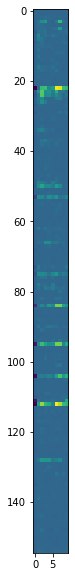

In [422]:
num_roi = tr_crude.num_roi.values[0]
p_pre_answer = np.empty(num_roi)
for ppa in tr_crude.p_pre_answer.values:
    p_pre_answer = np.vstack((p_pre_answer, -np.log10(ppa)))
p_pre_answer = p_pre_answer.transpose()
fig, ax = plt.subplots(figsize=(5,10))
ax.imshow(p_pre_answer)
